In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2

In [ ]:
data_path = '../../output/training_data/game5_set1_cleaned.csv'
df = pd.read_csv(data_path)

In [ ]:
features_path = '../../output/training_data/game5_set1_features.csv'
df_features = pd.read_csv(features_path)

In [57]:
df_features

,prev_mean_cy,prev_max_cy,prev_std_cy,next_mean_cy,next_max_cy,next_std_cy,prev_mean_cx,prev_max_cx,prev_std_cx,next_mean_cx,...,prev_std_energy,next_mean_energy,next_max_energy,next_std_energy,prev_mean_conf,prev_max_conf,prev_std_conf,next_mean_conf,next_max_conf,next_std_conf
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37072,590.833333,659.5,30.915574,606.875000,624.5,14.952007,1416.988889,1825.0,268.810143,1882.625000,...,566.650072,334.312500,522.0,168.633895,0.734089,0.8853,0.224588,0.769175,0.7954,0.032579
37073,591.055556,659.5,30.857116,612.333333,624.5,12.513326,1439.077778,1844.5,261.954673,1891.333333,...,539.331664,395.666667,522.0,141.668922,0.734544,0.8853,0.224615,0.766600,0.7954,0.039400
37074,591.222222,659.5,30.832862,618.750000,624.5,8.131728,1460.511111,1856.5,255.554913,1898.250000,...,518.818353,332.500000,422.5,127.279221,0.735458,0.8853,0.224704,0.752200,0.7827,0.043134
37075,591.422222,659.5,30.857251,624.500000,624.5,0.000000,1481.388889,1877.5,250.218677,1903.500000,...,462.767171,242.500000,242.5,0.000000,0.740384,0.8853,0.223504,0.782700,0.7827,0.000000


In [51]:
def plot_size_distribution(df, img_width=1920, img_height=1080):
    # Calculate 'size' (could be area or average of width/height)
    df['w'] = abs(df['x2'] - df['x1'])
    df['h'] = abs(df['y2'] - df['y1'])
    df['ball_size'] = np.log((df['w'] + df['h']) / 2)
    
    plt.figure(figsize=(12, 8))
    
    # Scatter plot where 'c' (color) is mapped to the ball size
    scatter = plt.scatter(
        df['cx'], 
        df['cy'], 
        c=df['ball_size'], 
        cmap='viridis', 
        alpha=0.6, 
        s=10 # Size of the dots in the plot
    )
    
    plt.colorbar(scatter, label='Average Ball Size (pixels)')
    plt.xlim(0, img_width)
    plt.ylim(img_height, 0)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Ball Size Variation across Frame (Perspective Calibration)")
    plt.show()

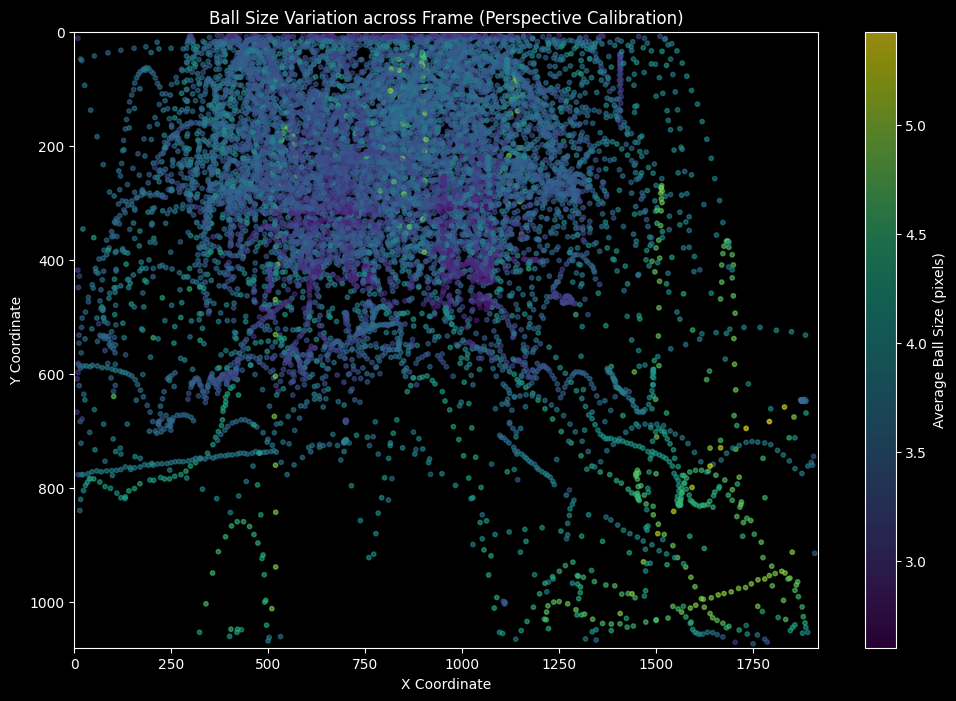

In [73]:
plot_size_distribution(df)

In [99]:
def plot_size_variance(df, grid_size=(40, 40), img_width=1920, img_height=1080):
    # 1. Calculate size
    df['ball_size'] = np.log((abs(df['x2'] - df['x1']) + abs(df['y2'] - df['y1'])) / 2)
    
    # 2. Binning with explicit ranges to match image dimensions
    x_bins = np.linspace(0, img_width, grid_size[0] + 1)
    y_bins = np.linspace(0, img_height, grid_size[1] + 1)
    
    # 3. Create the pivot table
    # We group by Y then X so that Y becomes the rows (vertical axis) naturally
    stats = df.groupby([
        pd.cut(df.cy, bins=y_bins, labels=False), 
        pd.cut(df.cx, bins=x_bins, labels=False)
    ])['ball_size'].std().unstack()

    plt.figure(figsize=(12, 7))
    
    # 4. Plotting
    # we don't need .T if we grouped (Y, X)
    sns.heatmap(stats, cmap='magma', cbar_kws={'label': 'Size Std Dev (Pixels)'})
    
    plt.title("Size Variance: Yellow = Depth Overlap / Purple = Consistent Depth")
    plt.xlabel("X (Pixels - Binned)")
    plt.ylabel("Y (Pixels - Binned: 0 is Top)")
    plt.show()

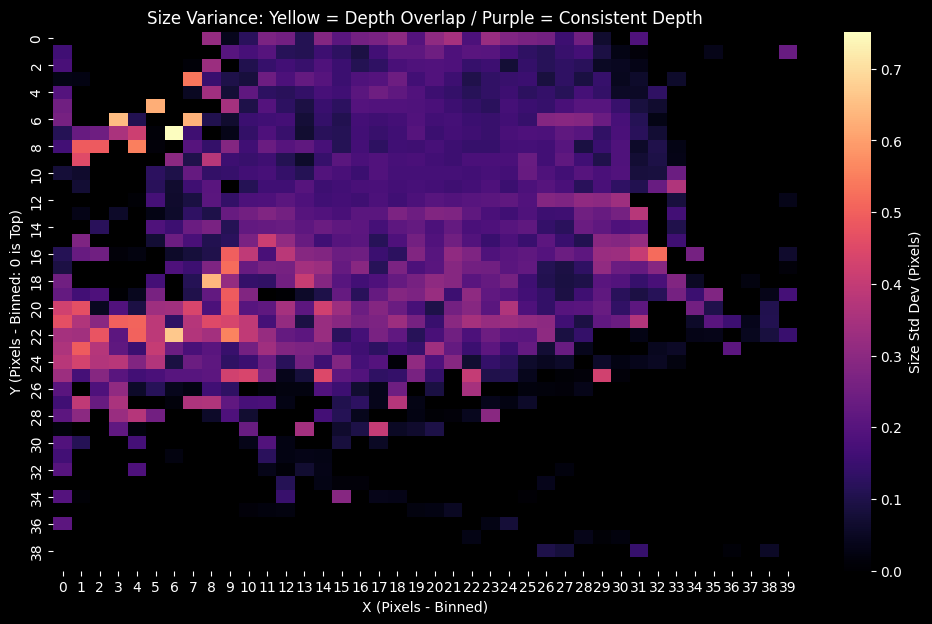

In [102]:
plot_size_variance(df)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def analyze_court_directions_from_motion(csv_path, jump_threshold=50):
    df = pd.read_csv(csv_path)

    # --- 1) Compute motion vectors ---
    df['dx'] = df['cx'].diff()
    df['dy'] = df['cy'].diff()
    df['dw'] = df['w'].diff()

    # Drop NaNs
    motion = df[['dx','dy','dw']].dropna()

    # --- 2) Remove tracking jumps in 3D ---
    dist3d = np.sqrt(motion.dx**2 + motion.dy**2 + motion.dw**2)
    motion = motion[dist3d < jump_threshold]

    # --- 3) Keep only 2D for court orientation ---
    vec2d = motion[['dx','dy']].values

    # --- 4) Normalize EACH vector to unit length (CRUCIAL) ---
    norms = np.linalg.norm(vec2d, axis=1, keepdims=True)
    vec2d = vec2d[norms[:,0] > 1]       # remove tiny jitters
    vec2d = vec2d / np.linalg.norm(vec2d, axis=1, keepdims=True)

    # --- 5) PCA on directions (NOT scaled data) ---
    pca = PCA(n_components=2)
    pca.fit(vec2d)

    main_axis = pca.components_[0]   # court length
    cross_axis = pca.components_[1]  # court width

    # Convert to angles (degrees)
    ang_main = np.degrees(np.arctan2(main_axis[1], main_axis[0]))
    ang_cross = np.degrees(np.arctan2(cross_axis[1], cross_axis[0]))

    print("\nEstimated court directions (image space):")
    print(f"Court length angle: {ang_main:.2f}°")
    print(f"Court width angle:  {ang_cross:.2f}°")
    print(f"Explained variance: {pca.explained_variance_ratio_}")

    # --- Visualization ---
    plt.figure(figsize=(6,6))
    plt.scatter(vec2d[:,0], vec2d[:,1], s=2, alpha=0.1)

    for v, c, label in [
        (main_axis, 'red', 'Length'),
        (cross_axis, 'blue', 'Width')
    ]:
        plt.quiver(0,0, v[0], v[1], color=c, scale=5, width=0.005)
        plt.text(v[0]*1.2, v[1]*1.2, label, color=c, fontsize=12)

    plt.axhline(0,color='gray'); plt.axvline(0,color='gray')
    plt.title("Dominant Motion Directions (Court Axes)")
    plt.axis('equal')
    plt.show()

    return pca, main_axis, cross_axis

# analyze_3d_motion_vectors('ball_detections.csv')

In [72]:
data_path = '../../output/training_data/game5_set1_cleaned.csv'
df = pd.read_csv(data_path)


Estimated court directions (image space):
Court length angle: 90.09°
Court width angle:  0.09°
Explained variance: [0.55170031 0.44829969]


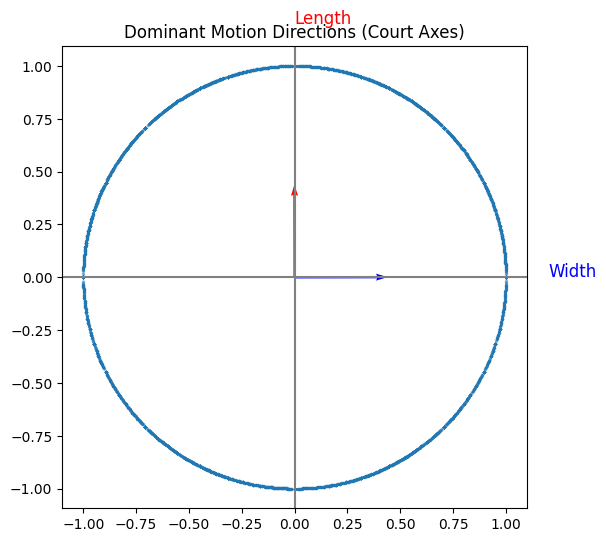

(PCA(n_components=2),
 array([-0.00156973,  0.99999877]),
 array([0.99999877, 0.00156973]))

In [73]:
analyze_court_directions_from_motion(data_path)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ==========================================================
#  AUTOMATIC COURT-LINE ESTIMATOR + OVERLAY
# ==========================================================

def estimate_court_axes_with_overlay(
    csv_path,
    jump_threshold=50,
    min_motion=1.0,
    sample_rate=1.0
):
    """
    INPUT CSV must contain at least:
      - cx : ball center x
      - cy : ball center y
      - w  : detected ball width (size proxy)

    RETURNS:
      main_axis   -> court length direction in image
      cross_axis  -> court width direction in image
      pca         -> fitted PCA model
    """

    # ------------------------------------------------------
    # 1) LOAD DATA
    # ------------------------------------------------------
    df = pd.read_csv(csv_path)

    # Compute frame-to-frame motion
    df['dx'] = df['cx'].diff()
    df['dy'] = df['cy'].diff()
    df['dw'] = df['w'].diff()

    motion = df[['cx','cy','dx','dy','dw']].dropna()

    # ------------------------------------------------------
    # 2) REMOVE TRACKING JUMPS (3D FILTER)
    # ------------------------------------------------------
    dist3d = np.sqrt(
        motion.dx**2 +
        motion.dy**2 +
        motion.dw**2
    )

    motion = motion[dist3d < jump_threshold]

    # ------------------------------------------------------
    # 3) BUILD CLEAN 2D DIRECTION VECTORS
    # ------------------------------------------------------
    vec2d = motion[['dx','dy']].values

    # Remove tiny jitter
    norms = np.linalg.norm(vec2d, axis=1)
    vec2d = vec2d[norms > min_motion]

    # Normalize to unit length (CRUCIAL for orientation)
    vec2d = vec2d / np.linalg.norm(vec2d, axis=1, keepdims=True)

    # Optional subsampling for speed
    if sample_rate < 1.0:
        mask = np.random.rand(len(vec2d)) < sample_rate
        vec2d = vec2d[mask]

    # ------------------------------------------------------
    # 4) PCA TO FIND COURT AXES
    # ------------------------------------------------------
    pca = PCA(n_components=2)
    pca.fit(vec2d)

    main_axis  = pca.components_[0]   # court length
    cross_axis = pca.components_[1]   # court width

    # Convert to angles (for your reference)
    ang_main  = np.degrees(np.arctan2(main_axis[1],  main_axis[0]))
    ang_cross = np.degrees(np.arctan2(cross_axis[1], cross_axis[0]))

    print("\n=== Estimated Court Orientation ===")
    print(f"Court length angle: {ang_main:.2f}°")
    print(f"Court width angle:  {ang_cross:.2f}°")
    print("Explained variance:", pca.explained_variance_ratio_)

    # ------------------------------------------------------
    # 5) OVERLAY ON YOUR BALL SCATTER PLOT
    # ------------------------------------------------------
    plt.figure(figsize=(8,8))

    # Plot your ball detections
    plt.scatter(df['cx'], df['cy'], s=3, alpha=0.15, label="Ball detections")

    # Compute plot center
    cx0 = df['cx'].mean()
    cy0 = df['cy'].mean()

    # Choose a nice visual scale
    scale = 400

    # Draw court length axis
    plt.quiver(
        cx0, cy0,
        main_axis[0]*scale,
        main_axis[1]*scale,
        color='red', width=0.003,
        label='Court Length'
    )

    # Draw court width axis
    plt.quiver(
        cx0, cy0,
        cross_axis[0]*scale,
        cross_axis[1]*scale,
        color='blue', width=0.003,
        label='Court Width'
    )

    plt.gca().invert_yaxis()   # match image coordinates
    plt.axis('equal')
    plt.legend()
    plt.title("Auto Court Axes Estimated from Ball Motion")
    plt.show()

    return pca, main_axis, cross_axis



=== Estimated Court Orientation ===
Court length angle: 90.09°
Court width angle:  0.09°
Explained variance: [0.55170031 0.44829969]


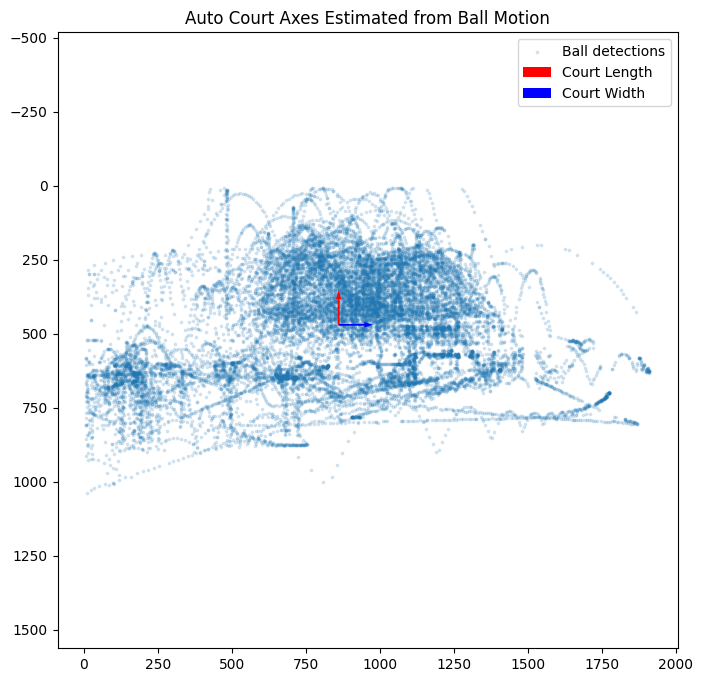

In [75]:
pca, length_dir, width_dir = estimate_court_axes_with_overlay(
    data_path
)
